# Deploy & Run Stable Diffusion on SageMaker & Inf2

This sample shows how to compile a pre-trained [HF Stable Diffusion 2.1](https://huggingface.co/stabilityai/stable-diffusion-2-1) to [Inferentia2](https://aws.amazon.com/ec2/instance-types/inf2/) on SageMaker.

The compilation is done on a trn1.2xlarge instance, given NeuronSDK requires NeuronCore v2 to do the job. Stable Diffusion is a large model, that's why it requires a large instance to be compiled. The compilation time on a trn1.2xlarge is ~24.2mins. 
(Estimated compilation cost on 2023 May 13 - us-west-2 ml.trn1.2xlarge \\$1.54/h ::: 24.2mins=$0.621)

## 1) Install some dependencies

In [ ]:
%pip install -U sagemaker

## 2) Initialize variables
Not all regions have trn1 and inf2 instances available. At the time this notebook was published, us-east-1 has trn1 instances and us-east-2 has inf2 instances. That way, we need to create two sagemaker sessions: 1/ for compiling the model (us-east-1); 2/ for deploying the model (us-east-2).

In [ ]:
import boto3
import sagemaker
import numpy as np

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

region_trn1='us-west-2'
boto3_sess_trn1 = boto3.Session(region_name=region_trn1) # trn1 session
sess_trn1 = sagemaker.Session(boto3_sess_trn1)

region_inf2='us-east-2'
boto3_sess_inf2 = boto3.Session(region_name=region_inf2) # inf2 session
sess_inf2 = sagemaker.Session(boto3_sess_inf2)

bucket_trn1 = sess_trn1.default_bucket()
bucket_inf2 = sess_inf2.default_bucket()
role = sagemaker.get_execution_role()

# https://github.com/aws/deep-learning-containers/blob/master/available_images.md#neuron-containers
train_image_name="pytorch-training-neuronx"
inference_image_name="pytorch-inference-neuronx"
# We need SDK2.10+ to deal with SDs
image_tag="1.13.1-neuronx-py38-sdk2.10.0-ubuntu20.04"

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket trn1: {bucket_trn1}")
print(f"sagemaker bucket trn1: {bucket_inf2}")
print(f"sagemaker session regions. trn1: {region_trn1} inf2: {region_inf2}")

## 3) Visualize scripts
We have 3 scripts that will do the job. 
  - src/wrapper.py: Helper class created to wrap the model and expose the parts that we will compile to inf2. It is also a way to put everything back together to compose a pipeline.
  - src/compile.py: NeuronSDK compilation script that makes use of the wrapper, splits the model into 4 parts and compile each one individually.
  - src/inference.py: SageMaker inference script that also makes use of wrapper to reload the compiled parts and re-build the pipeline responsible for getting the predictions.

In [ ]:
!pygmentize src/wrapper.py

In [ ]:
!pygmentize src/compile.py

In [ ]:
!pygmentize src/inference.py

## 4) Compile the model

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="compile.py", # Specify your train script
    source_dir="src",
    image_uri=f"763104351884.dkr.ecr.{region_trn1}.amazonaws.com/{train_image_name}:{image_tag}",
    role=role,
    sagemaker_session=sess_trn1,
    instance_count=1,
    instance_type='ml.trn1.2xlarge',
    disable_profiler=True,
    output_path=f"s3://{bucket_trn1}/output",    
    volume_size = 384,
    
    # Parameters required to enable checkpointing
    # This is necessary for caching XLA HLO files and reduce training time next time    
    checkpoint_s3_uri=f"s3://{bucket_trn1}/checkpoints",
    
)
estimator.framework_version = '1.13.1' # workround when using image_uri
estimator._is_compiled_model = True

In [ ]:
# it takes around 1452 seconds to complete the job on a trn1.2xlarge
# You will run this just once to compile the model.
estimator.fit()

## 5) Deploy the model to inferentia2
We compiled the model in one region but we'll deploy to another region. So, we need to copy the models artifacts first and then create a PyTorchModel

In [ ]:
import boto3
s3 = boto3.resource('s3', region_name=region_trn1)

model_name="stable-diffusion-neuron-inferentia"
model_data=f"s3://{sess_inf2.default_bucket()}/{model_name}/model.tar.gz"
copy_source = {
    'Bucket': sess_trn1.default_bucket(),
    'Key': estimator.model_data.split('/', 3)[-1]
}
s3.meta.client.copy(copy_source, sess_inf2.default_bucket(), f'{model_name}/model.tar.gz')

In [12]:
import logging
from sagemaker.pytorch.model import PyTorchModel

# depending on the inf2 instance you deploy the model you'll have more or less accelerators
# we'll ask SageMaker to launch 1 worker per accelerator

instance_type_idx=2 # default ml.inf2.24xlarge
instance_types=['ml.inf2.xlarge', 'ml.inf2.8xlarge', 'ml.inf2.24xlarge','ml.inf2.48xlarge']
num_workers=[1,1,6,12]

print(f"Instance type: {instance_types[instance_type_idx]}. Num SM workers: {num_workers[instance_type_idx]}")
pytorch_model = PyTorchModel(
    image_uri=f"763104351884.dkr.ecr.{region_inf2}.amazonaws.com/{inference_image_name}:{image_tag}",
    model_data=model_data,
    role=role,    
    name=model_name,
    sagemaker_session=sess_inf2,
    container_log_level=logging.DEBUG,
    model_server_workers=num_workers[instance_type_idx], # 1 worker per inferentia chip
    framework_version="1.13.1",
    env = {
        'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '3600' 
    }
    # for production it is important to define vpc_config and use a vpc_endpoint
    #vpc_config={
    #    'Subnets': ['<SUBNET1>', '<SUBNET2>'],
    #    'SecurityGroupIds': ['<SECURITYGROUP1>', '<DEFAULTSECURITYGROUP>']
    #}
)
pytorch_model._is_compiled_model = True

Instance type: ml.inf2.24xlarge. Num SM workers: 6


In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type=instance_types[instance_type_idx],
    model_data_download_timeout=3600, # it takes some time to download all the artifacts and load the model
    container_startup_health_check_timeout=1800
)

## 6) Run a simple test

In [ ]:
from sagemaker.serializers import DataSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = DataSerializer(content_type='plain/text')
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

6 images generated in 2.46s. Showing the first image...


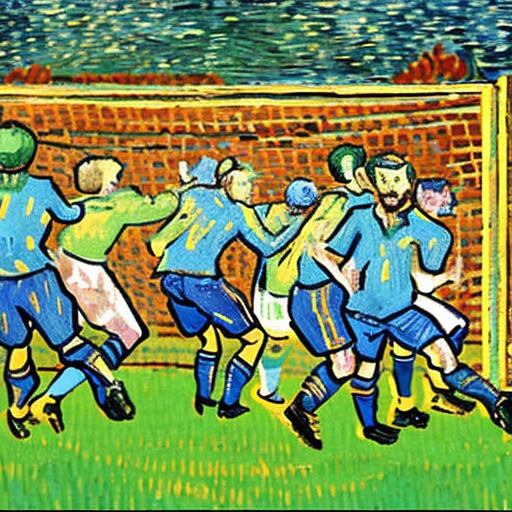

In [210]:
import io
import time
from PIL import Image
from multiprocessing.pool import ThreadPool

# adjust this number according to the instance size and number of workers
num_clients = num_workers[instance_type_idx]
input_text="football match; van gogh style"
input_texts=[input_text] * num_clients

def predict(text):
    data = predictor.predict(input_text.encode('utf-8'))    
    return data

with ThreadPool(num_clients) as p:
    t=time.time()
    data = p.map(predict, input_texts)
    print(f"{len(data)} images generated in {(time.time()-t):0.2f}s. Showing the first image...")
Image.open(io.BytesIO(data[0]))